In [5]:
import numpy as np
import pandas as pd
import time
import random
import matplotlib.pyplot as plt
import time
import requests
import math
from datetime import datetime, timedelta
import requests

In [8]:
def capital_function(num_A, num_B, price_A, price_B):
    return num_A*price_A + num_B*price_B

In [ ]:
def IU_decision_function(token1, token2, alpha, fee, price_A, price_B):
    """
        The decision-making function of informed users based on their current capital and market situation

        Return: how much tokens user is ready to exchange
    """

    # Calculate the optimal delta_x* and delta_y*

    x = token1
    y = token2
    q = price_A / price_B

    delta_x_star = (np.sqrt(x*y/q) - x) / (1-alpha)
    # print('Root: ', x*y/((1-alpha)*q))
    # print('Знаменатель1: ', (1-alpha)*q)
    # print('Знаменатель2: ', x + delta_x_star*(1-alpha))
    if delta_x_star == 0:
        delta_x_star = 1
        
    delta_y_star = x*y / (x + delta_x_star*(1-alpha)) - y
    if delta_x_star > 0:
        delta_x_star = np.clip(delta_x_star, 1, x)                                  # пользователь не может приобрести больше чем есть в пуле
    else:
        delta_y_star = np.clip(delta_y_star, 1, y)
        
    # print(delta_x_star, delta_y_star)

    delta_P = capital_function(delta_x_star, delta_y_star, price_A, price_B) - fee
    print(f'IU: delta_P={delta_P}, delta_x={delta_x_star}, delta_y={delta_y_star}')
    if delta_P > 0:
        return delta_x_star, delta_y_star, delta_P                                 # token1, token2; знаки относительно пользователя
    else:
        return 0, 0, 0

In [ ]:
def UU_decision_function(token1, token2, alpha, fee, price_A, price_B):
    """
        The decision-making function of uninformed users based on their current capital and market situation

        Return: how much tokens user is ready to exchange
    """
    # Choose which token UU will buy
    
    # Идея: если цена p_CEX токена А больше p_CEX токена В
    # то с вероятность 60% UU покупает токен А
    if price_A > price_B:
        p_token_1 = 0.6
    else:
        p_token_1 = 0.4
    token_choices = np.random.choice(['token1', 'token2'], size=1, p=[p_token_1, 1 - p_token_1])

    if token_choices == 'token1':
        token_buy = token1
        token_sell = token2
        p_token_buy = price_A
        p_token_sell = price_B
    else:
        token_buy = token2
        token_sell = token1
        p_token_buy = price_B
        p_token_sell = price_A

    # Пусть пользователь будет покупать 0.05% +- 0.01% от всего пула
    mu = 0.0005
    sigma = 0.0001
    share = np.random.normal(mu, sigma)
    delta_tokens_buy = token_buy * share
    # delta_tokens_buy = np.clip(delta_tokens_buy, 1, token_buy)        # проверка что собрались покупать меньше чем всего есть в пуле

    # delta_tokens_sell = token_buy * token_sell / (token_buy + delta_tokens_buy*(1-alpha)) - token_sell
    # delta_tokens_sell = token_sell - token_buy * token_sell / (token_buy + delta_tokens_buy*(1-alpha))
    delta_tokens_sell = token_sell - token_buy * token_sell / (token_buy - delta_tokens_buy*(1-alpha))
    delta_P = capital_function(delta_tokens_buy, delta_tokens_sell, p_token_buy, p_token_sell) - fee
    total_change = capital_function(abs(delta_tokens_buy), abs(delta_tokens_sell), p_token_buy, p_token_sell)
    print(f'UU: delta_P={delta_P}, delta_buy={delta_tokens_buy}, delta_sell={delta_tokens_sell}')

    
    if total_change != 0:
        r = delta_P / total_change
    else:
        r = -1000
    
    if r >= 0:
        return delta_tokens_sell, delta_tokens_buy, delta_P
    else:
        # Пользователь подкидывает несимметричную монетку и по ней решает
        # Вероятность успеха эеспоненциально падает при увеличении абсолютного значения r

        # Вероятность сделки
        probability_of_trade = np.exp(-abs(r))
        # Случайное число от 0 до 1
        random_value = np.random.rand()
        # Подбрасываем несимметричную монетку
        if random_value < probability_of_trade:
            if token_choices == 'token1':
                return delta_tokens_buy, delta_tokens_sell, delta_P      # token1, token2; знаки относительно пользователя
            else:
                return delta_tokens_sell, delta_tokens_buy, delta_P      # token1, token2; знаки относительно пользователя
        else:
            return 0, 0, 0

In [ ]:
def price_DEX(x_new, y_new):
    return y_new / x_new, x_new / y_new

def poisson_process_time_generation(rate):
    """
        Generates the time until the next event in the Poisson process
    """
    return np.random.exponential(1/rate)

def generate_dex_actions_real_prices(lambda_IU, lambda_UU, alpha, fee, token1, token2,  price_A_arr, price_B_arr, duration):
    """
        Generating the sequence of IU and UU actions in DEX within 'duration' seconds
        Actions are generated as two independent Poisson flows for IU and UU
    """
    current_time = 0
    actions = []        # array of arrays [time, type of user, delta x, delta y, profit]
    profit_IU = []
    profit_UU = []
    profit_LP = []
    p_DEX_arr = []
    price_DEX_token1, price_DEX_token2 = price_DEX(token1, token2)      # calculate initial DEX prices

    # First action initialization
    next_IU_time = poisson_process_time_generation(lambda_IU)
    next_UU_time = poisson_process_time_generation(lambda_UU)
    
    while current_time < duration:
        closest_index = int(math.floor(current_time))
        price_A = price_A_arr.iloc[closest_index]
        price_B = price_B_arr.iloc[closest_index]
        if next_IU_time < next_UU_time:

            current_time += next_IU_time
            if current_time > duration:
                break

            Delta_x, Delta_y, prof_iu = IU_decision_function(token1, token2, alpha, fee, price_A, price_B)
            profit_IU.append(prof_iu)
            if (Delta_x == 0) & (Delta_y == 0):
                profit_LP.append(0)
                actions.append([current_time, 'LP', 0, 0, 0])
            else:
                profit_LP.append(capital_function(-Delta_x, -Delta_y, price_A, price_B) + fee)
                actions.append([current_time, 'LP', -Delta_x, -Delta_y, capital_function(-Delta_x, -Delta_y, price_A, price_B) + fee])

            # Меняем число токенов в пуле
            token1 -= Delta_x               # -= так как знаки дельт относительно пользователя
            token2 -= Delta_y
            if (token1 <= 0) | (token2 <= 0):
                break

            if Delta_x > 0:
                p_DEX_arr.append(price_DEX_token2)
            else:
                p_DEX_arr.append(price_DEX_token1)

            price_DEX_token1, price_DEX_token2 = price_DEX(token1, token2)
            
            actions.append([current_time, 'IU', Delta_x, Delta_y, prof_iu])
            next_IU_time = poisson_process_time_generation(lambda_IU)
            
        else:
            current_time += next_UU_time
            if current_time > duration:
                break
            Delta_x, Delta_y, prof_uu = UU_decision_function(token1, token2, alpha, fee, price_A, price_B)
            profit_UU.append(prof_uu)

            if (Delta_x == 0) & (Delta_y == 0):
                profit_LP.append(0)
                actions.append([current_time, 'LP', 0, 0, 0])
            else:
                profit_LP.append(capital_function(-Delta_x, -Delta_y, price_A, price_B) + fee)
                actions.append([current_time, 'LP', -Delta_x, -Delta_y, capital_function(-Delta_x, -Delta_y, price_A, price_B) + fee])
                
            actions.append([current_time, 'UU', Delta_x, Delta_y, prof_uu])
            token1 -= Delta_x
            token2 -= Delta_y
            
            if (token1 <= 0) | (token2 <= 0):
                break
                # token1 = 1000000
                # token2 = token1 * price_A/price_B

            price_DEX_token1, price_DEX_token2 = price_DEX(token1, token2)
            next_UU_time = poisson_process_time_generation(lambda_UU)
        print(f'Token1: {token1}, Token2: {token2}')
        print('\n\n')
    return actions, profit_IU, profit_UU, profit_LP, p_DEX_arr


In [ ]:
def get_historical_data(symbol, interval, start_time, end_time):
    """
        Получение исторических данных по ценам для указанной торговой пары.
        
        symbol: Торговая пара (например, "ETHBTC").
        interval: Интервал свечей (например, "1d" для дневных данных).
        start_time: Начало периода в формате timestamp.
        end_time: Конец периода в формате timestamp.
    """
    url = "https://api.binance.com/api/v3/klines"
    params = {  'symbol': symbol,
                'interval': interval,
                'startTime': start_time,
                'endTime': end_time,
                'limit': 1000   }  # Binance позволяет получать максимум 1000 свечей за один запрос

    data = []
    while True:
        response = requests.get(url, params=params)
        temp_data = response.json()
        if not temp_data:
            break
        data.extend(temp_data)
        params['startTime'] = temp_data[-1][0] + 1
    return data

symbol = "ETHBTC"
interval = "5m"  # Интервал для данных
end_time = int(datetime.now().timestamp() * 1000)  # Конечное время (сейчас)
start_time = int((datetime.now() - timedelta(days=3)).timestamp() * 1000)  # Начальное время (3 дня назад)
historical_data = get_historical_data(symbol, interval, start_time, end_time)

columns = ["Open time", "Open", "High", "Low", "Close", "Volume", 
           "Close time", "Quote asset volume", "Number of trades", 
           "Taker buy base asset volume", "Taker buy quote asset volume", "Ignore"]
df = pd.DataFrame(historical_data, columns=columns)
df["Open time"] = pd.to_datetime(df["Open time"], unit='ms')
df["Close time"] = pd.to_datetime(df["Close time"], unit='ms')

In [207]:
duration = len(df['Open']) - 1
lambda_IU = 2                  # частота действий для IU
lambda_UU = 2                  # частота действий для UU
price_A_arr = pd.to_numeric(df['Open'])[1:]
price_B_arr = 1/pd.to_numeric(df['Open'])[1:]

initial_token1 = 1000000         # количество токенов в пуле
initial_token2 = initial_token1 * pd.to_numeric(df['Open'])[0] / (1/pd.to_numeric(df['Open'])[0])
alpha = 0.1
fee = 0.5

print(f'INIT TOKEN1: {initial_token1}, INIT TOKEN2: {initial_token2}\n')
actions, profit_IU_arr, profit_UU_arr, profit_LP_arr, p_DEX_IU_arr = generate_dex_actions_real_prices(lambda_IU, lambda_UU, alpha, fee, initial_token1, initial_token2, price_A_arr[1:], price_B_arr[1:], duration)

INIT TOKEN1: 1000000, INIT TOKEN2: 1260.25

UU: delta_P=2.449822334582567, delta_buy=1.0, delta_sell=-714.654385198839
Token1: 1000714.6543851988, Token2: 1259.25



UU: delta_P=2.4116233804389573, delta_buy=1.0, delta_sell=-715.7334517000709
Token1: 1001430.3878368989, Token2: 1258.25



IU: delta_P=4.610472407724231, delta_x=1460.8988063628526, delta_y=-1.6498292249482347
Token1: 999969.489030536, Token2: 1259.8998292249482



IU: delta_P=9.864702533908698, delta_x=3000.8243670073957, delta_y=-3.3936025940586205
Token1: 996968.6646635287, Token2: 1263.2934318190069



UU: delta_P=0.938713915273258, delta_buy=464.89135200788553, delta_sell=-0.5303944941554164
Token1: 996969.1950580229, Token2: 798.4020798111213



UU: delta_P=5.469627584321003, delta_buy=398.7843747164837, delta_sell=-0.2875258763439206
Token1: 996969.4825838992, Token2: 399.61770509463764



UU: delta_P=-51.61034969555354, delta_buy=1.0, delta_sell=-2250.3955125657376
Token1: 996969.4825838992, Token2: 399.6177050946

In [214]:
actions # array of arrays [time, type of user, delta x, delta y, profit]

[[0.17146653684185897, 'LP', 714.654385198839, -1.0, -2.449822334582567],
 [0.17146653684185897, 'UU', -714.654385198839, 1.0, 2.449822334582567],
 [0.2560688146679284, 'LP', 715.7334517000709, -1.0, -2.4116233804389573],
 [0.2560688146679284, 'UU', -715.7334517000709, 1.0, 2.4116233804389573],
 [0.7387724140972336,
  'LP',
  -1460.8988063628526,
  1.6498292249482347,
  -4.610472407724231],
 [0.7387724140972336,
  'IU',
  1460.8988063628526,
  -1.6498292249482347,
  4.610472407724231],
 [1.2561850263355079,
  'LP',
  -3000.8243670073957,
  3.3936025940586205,
  -9.864702533908698],
 [1.2561850263355079,
  'IU',
  3000.8243670073957,
  -3.3936025940586205,
  9.864702533908698],
 [1.7744247356607254,
  'LP',
  0.5303944941554164,
  -464.89135200788553,
  -13146.861109727088],
 [1.7744247356607254,
  'UU',
  -0.5303944941554164,
  464.89135200788553,
  0.938713915273258],
 [2.7244634185361987,
  'LP',
  0.2875258763439206,
  -398.7843747164837,
  -11277.328484569278],
 [2.7244634185361987

In [215]:
map_sec_prof_iu = {}
map_sec_prof_uu = {}
map_sec_prof_lp = {}

for arr in actions:
    if arr[1] == 'IU':
        map_sec_prof_iu[arr[0]] = arr[4]
    elif arr[1] == 'UU':
        map_sec_prof_uu[arr[0]] = arr[4]
    else:
        map_sec_prof_lp[arr[0]] = arr[4]

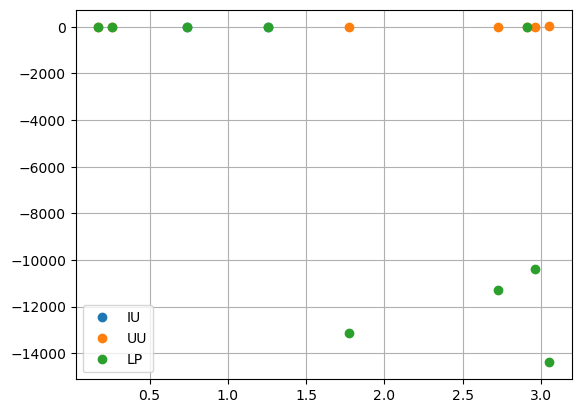

In [216]:
plt.plot(map_sec_prof_iu.keys(), map_sec_prof_iu.values(), marker= 'o', linestyle='None', label='IU')
plt.plot(map_sec_prof_uu.keys(), map_sec_prof_uu.values(), marker= 'o', linestyle='None', label='UU')
plt.plot(map_sec_prof_lp.keys(), map_sec_prof_lp.values(), marker= 'o', linestyle='None', label='LP')

plt.legend()
# plt.yscale('log')
plt.grid()
plt.show()

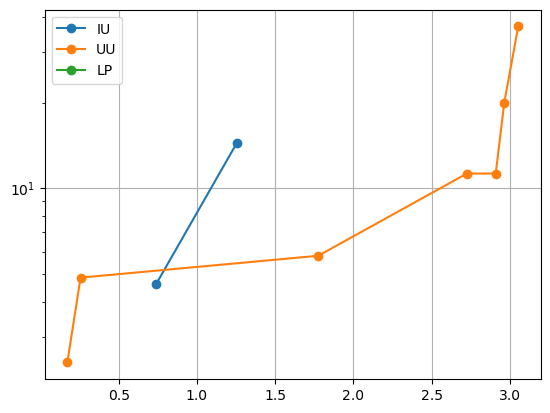

In [218]:
plt.plot(map_sec_prof_iu.keys(), np.cumsum(list(map_sec_prof_iu.values())), marker= 'o', label='IU')
plt.plot(list(map_sec_prof_uu.keys()), np.cumsum(list(map_sec_prof_uu.values())), marker= 'o', label='UU')
plt.plot(list(map_sec_prof_lp.keys()), np.cumsum(list(map_sec_prof_lp.values())), marker= 'o', label='LP')
# [:-2]
plt.legend()
plt.yscale('log')
plt.grid()
plt.show()

In [189]:
map_sec_prof_uu

{10.929442266939105: 928.1646555522493, 11.513556831669305: 67.36018679817775}